In [20]:
import numpy as np
import pandas as pd
import scanpy as sc
from sklearn.metrics import mean_squared_error, explained_variance_score
from numpy.linalg import inv, solve
import matplotlib.pyplot as plt
from utils_plot import *
from scipy.optimize import minimize_scalar
from scipy.stats import spearmanr
from sklearn.metrics.pairwise import cosine_similarity
import json

In [21]:
# 1. Data Normalization

def preprocessing(alpha1, alpha2, N, ampl_threshold=0):

    targetnames = np.array(list(set(N.index) & set(alpha1.index) & set(alpha2.index)))
    print("Genes in common :", len(targetnames))

    alpha1, alpha2 = alpha1.loc[targetnames].to_numpy(), alpha2.loc[targetnames].to_numpy()
 
    ampl1 = (alpha1.max(axis=1)-alpha1.min(axis=1))/2
    ampl2 = (alpha2.max(axis=1)-alpha2.min(axis=1))/2
    ind = (ampl1 > ampl_threshold) & (ampl2 > ampl_threshold)
    alpha1, alpha2 = alpha1[ind,:], alpha2[ind,:]
    targetnames_filtered = targetnames[ind]

    N = N.loc[targetnames_filtered].to_numpy()
    
    # Identify TFs that are not present in any gene
    inactive_tfs = np.where(N.sum(axis=0) == 0)[0]
    print(f"Number of inactive TFs: {len(inactive_tfs)}")
    N = np.delete(N, inactive_tfs, axis=1)
    tf_names_filtered = np.delete(tf_names, inactive_tfs)
    
    print(f"Kept genes: {N.shape[0]} (ampl > {ampl_threshold})")
    alpha1_norm = alpha1 - np.mean(alpha1, axis=1, keepdims=True) - np.mean(alpha1, axis=0, keepdims=True) + np.mean(alpha1)
    alpha2_norm = alpha2 - np.mean(alpha2, axis=1, keepdims=True) - np.mean(alpha2, axis=0, keepdims=True) + np.mean(alpha2)
    N_norm = N - np.mean(N, axis=0, keepdims=True)

    return alpha1_norm, alpha2_norm, N_norm, targetnames_filtered, tf_names_filtered

In [22]:
def svd_regression_with_lambda_selection(alpha, N, sigma2=0.1):
    """
    Perform regression using SVD and select the best regularization (lambda)
    using marginal likelihood.
    lambda1 = sigma2 (data noise) / tau2 (variance of prior on A)
    """

    # Step 1: SVD of N
    U, s, VT = np.linalg.svd(N, full_matrices=False)
    M = U.T @ alpha  # project alpha onto the SVD basis
    C = alpha.shape[1] #nb of theta

    def log_evidence(lambda1):
        """Compute log marginal likelihood (evidence) for given lambda."""
        denom = sigma2 + (s**2) / lambda1
        #denom = s**2 + lambda1  # sigma2 is absorbed
        #Term1 : penalize model complexity (if lambda is large, term is smaller)
        term1 = -0.5 * C * np.sum(np.log(denom))
        #Term2 : how well the data fit in the model. M represent the mismatch of alpha in the new basis.
        #Large M, small denominator, Bad — model should explain it well, but doesn't
        #Large M, large denominator, Okay-ish — model admits it can't explain well (high uncertainty)
        #Small M, Good — little mismatch, data aligns with prior or is close to 0
        term2 = -0.5 * np.sum((M**2) / denom[:, np.newaxis])
        
        residual = alpha - U @ M
        #Term3 : penalize unexplained variance (residuals)
        term3 = -0.5 * np.sum(residual**2) #/ sigma2
        
        return term1 + term2 + term3

    # Step 2: Optimize lambda
    result = minimize_scalar(lambda lambda1: -log_evidence(lambda1), bounds=(1e3, 1e7), method='bounded')
    lambda_opt = result.x
    lambdas = np.logspace(3, 7, 40)
    log_evs = [log_evidence(lam) for lam in lambdas]
    
    # Step 3: Compute posterior mean (final weights A)
    shrink = lambda_opt * s / (lambda_opt*sigma2+s**2)
    #shrink = s / (s**2 + lambda_opt) #ISMARA (get rid of sigma2)
    X = shrink[:, np.newaxis] * M
    A_star = VT.T @ X

    plt.plot(lambdas, log_evs)
    plt.xscale('log')
    plt.xlabel('Lambda')
    plt.ylabel('Log Marginal Likelihood')
    plt.title('Evidence vs Lambda')
    plt.grid(True)
    plt.show()

    return A_star, lambda_opt

In [23]:
def get_A_star(alpha, N, lambda_opt, sigma2=0.1):
    
    U, s, VT = np.linalg.svd(N, full_matrices=False)
    
    # Step 3: Compute posterior mean (final weights A)
    shrink = lambda_opt * s / (lambda_opt*sigma2+s**2)
    #shrink = s / (s**2 + lambda_opt) #ISMARA (get rid of sigma2)
    X = shrink[:, np.newaxis] * (U.T @ alpha)
    A = VT.T @ X
    
    return A

In [24]:
def standardize_amplitudes(matrices, target_amp=0.2):
    """
    Rescale the matrices to a single target amplitude.
    """
    standardized_matrices = []
    for matrix in matrices:
        amp = (np.max(matrix, axis=1) - np.min(matrix, axis=1)) / 2
        scale = target_amp / amp
        standardized_matrix = matrix * scale[:, np.newaxis]
        standardized_matrices.append(standardized_matrix)
    
    return standardized_matrices

(11582, 100) (11495, 100) (13568, 370)
Genes in common : 8447
Number of inactive TFs: 10
Kept genes: 812 (ampl > 0.2)
(812, 100) (812, 100) (812, 360)


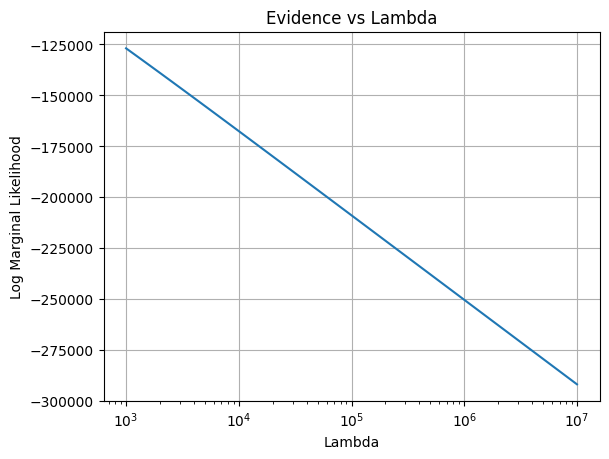

Best lambda: 1000.0000320358575


In [25]:
fileAlpha1 = "/shared/space2/molina/suttyg/alpha_snrna_rep1_5000_1_2p75.csv"
fileAlpha2 = "/shared/space2/molina/suttyg/alpha_snrna_rep2_5000_1_2p75.csv"
fileBSM = '/shared/space2/molina/suttyg/data_binding_site_matrix.txt'
process = ["transcription", "\u03B1"]
theta_smooth = np.round(np.linspace(0.01, 1.00, 100), 2)  # 100 bins from 0.01 to 1.00
sigma2 = 0.1

N = pd.read_csv(fileBSM, sep="\t",index_col=0)
tf_names = N.columns
alpha1 = pd.read_csv(fileAlpha1, sep=",",index_col=0)
alpha2 = pd.read_csv(fileAlpha2, sep=",",index_col=0)

#Select common genes and normalize
print(alpha1.shape, alpha2.shape, N.shape)
ampl_threshold=0.2
alpha1_norm, alpha2_norm, N_norm, targetnames, tf_names = preprocessing(alpha1, alpha2, N, ampl_threshold=ampl_threshold)
print(alpha1_norm.shape, alpha2_norm.shape, N_norm.shape)

A_star, lambda_opt = svd_regression_with_lambda_selection(alpha1_norm, N_norm, sigma2=sigma2)
print("Best lambda:", lambda_opt)

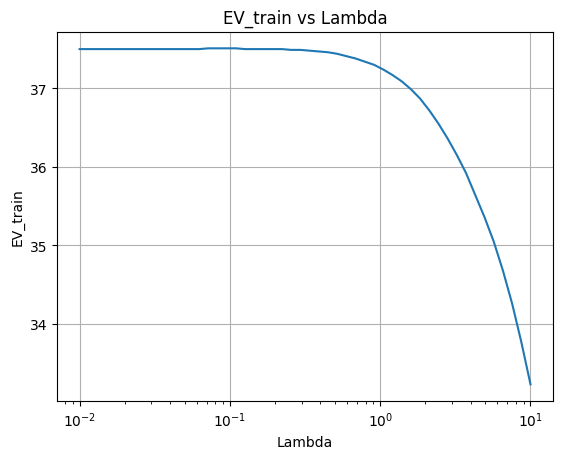

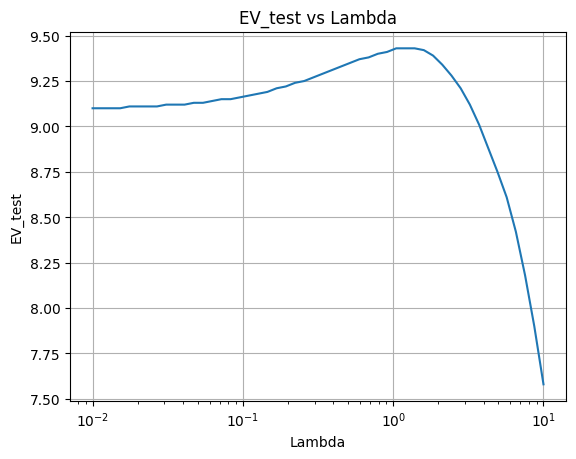

Best lambda_test = 1.0481131341546852


In [26]:
EVs_train = []
EVs_test = []
lambda_vals = np.logspace(-2, 1, 50)
alpha1_norm, alpha2_norm = standardize_amplitudes([alpha1_norm, alpha2_norm], target_amp=1)
for lambda1 in lambda_vals:
    
    A = get_A_star(alpha1_norm, N_norm, lambda1, sigma2=sigma2)
    R = N_norm @ A
    R = standardize_amplitudes([R], target_amp=1)[0]
    
    EV_train = round(explained_variance_score(alpha1_norm, R)*100,2)
    EV_test = round(explained_variance_score(alpha2_norm, R)*100,2)
    #print("EV_train :", EV_train, "%", "MSE_train :", round(mean_squared_error(alpha1_norm, R),2))
    #print("EV_test :", EV_test, "%", "MSE_test :", round(mean_squared_error(alpha2_norm, R),3), "\n")
    EVs_train.append(EV_train)
    EVs_test.append(EV_test)
del A
del R

plt.plot(lambda_vals, EVs_train)
plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('EV_train')
plt.title('EV_train vs Lambda')
plt.grid(True)
plt.show()

plt.plot(lambda_vals, EVs_test)
plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('EV_test')
plt.title('EV_test vs Lambda')
plt.grid(True)
plt.show()
best_EV_lambda = lambda_vals[np.argmax(EVs_test)]
print("Best lambda_test =", best_EV_lambda)

In [27]:
#EV at optimum lambda
print(f"EV at lambda_opt = {lambda_opt:.2f}")
A_star = get_A_star(alpha1_norm, N_norm, lambda_opt, sigma2=sigma2) #best_EV_lambda
R = N_norm @ A_star
R = standardize_amplitudes([R], target_amp=1)[0]
print("EV_train :", round(explained_variance_score(alpha1_norm, R)*100,2), "%")#, "MSE_train :", round(mean_squared_error(alpha1_norm, R),2))
print("EV_test :", round(explained_variance_score(alpha2_norm, R)*100,2), "%")#, "MSE_test :", round(mean_squared_error(alpha2_norm, R),3))

EV at lambda_opt = 1000.00
EV_train : -10.15 %
EV_test : -20.67 %


In [28]:
with open('/shared/space2/molina/suttyg/gene_phase_dict.json', 'r') as f:
    d = json.load(f)
cyclic_genes = d['G1/S']+d['G2/M']
print(cyclic_genes)

['Pold3', 'Rad51', 'Pcna', 'Mcm6', 'Dtl', 'Chaf1b', 'Usp1', 'Fen1', 'Atad2', 'Mcm4', 'Rrm1', 'Rfc2', 'Casp8ap2', 'Rpa2', 'Clspn', 'Gmnn', 'Ccne2', 'E2f8', 'Hells', 'Mcm2', 'Exo1', 'Prim1', 'Rad51ap1', 'Slbp', 'Gins2', 'Msh2', 'Dscc1', 'Blm', 'Tipin', 'Rrm2', 'Cdc45', 'Mlf1ip', 'Pola1', 'Tyms', 'Ung', 'Brip1', 'Wdr76', 'Cdc6', 'Nasp', 'Uhrf1', 'Ubr7', 'Cdca7', 'Hmgb2', 'Ckap2', 'Ctcf', 'G2e3', 'Ncapd2', 'Ndc80', 'Nusap1', 'Ttk', 'Ccnb2', 'Cdc20', 'Kif20b', 'Cdc25c', 'Ube2c', 'Cenpa', 'Aurka', 'Top2a', 'Tacc3', 'Tubb4b', 'Kif11', 'Ect2', 'Gas2l3', 'Cbx5', 'Nek2', 'Hjurp', 'Hn1', 'Cenpf', 'Cks1b', 'Bub1', 'Cks2', 'Psrc1', 'Kif23', 'Ckap2l', 'Aurkb', 'Mki67', 'Kif2c', 'Tmpo', 'Gtse1', 'Nuf2', 'Dlgap5', 'Lbr', 'Hmmr', 'Tpx2', 'Fam64a', 'Rangap1', 'Anp32e', 'Cdca8', 'Cdca3', 'Anln', 'Cdk1', 'Cdca2', 'Smc4']


In [29]:
#Check EV for known cyclic genes
#cyclic_genes = ["Nusap1", "Tpx2", "Kif11", "Ccnb1", "Cdk1", "Cdc20", "Top2a", "Cenpe", "Aurka", "Anln", "Prc1", "Pcna", "Mcm2", "Mcm3", "Mcm4", "Mcm5", "Mcm6", "Cdc6", "Rrm1", "Rrm2", "Ect2", "Ccne1", "Ccne2", "Cdc25a", "Chek1", "Cdc25c"]
EVs = []
c = 0
for cyclic_gene in cyclic_genes:
    try:
        n = np.where(targetnames == cyclic_gene)[0][0]
        EV = round(explained_variance_score(alpha1_norm[n, :], R[n, :])*100,2)
        EVs.append(EV)
    except:
        c += 1
print(c, "/",len(cyclic_genes), "genes not in the list.")
EVs = np.array(EVs)
print(round(np.mean(EVs), 2), "% (proportion of pos EV :", round(np.sum(EVs > 0)/len(EVs)*100, 2), "%)")
#print("Train")
#plot_rate_comparison(targetnames, alpha1_norm, R, process, theta_smooth, target_nb=n)
#print("Test")
#plot_rate_comparison(targetnames, alpha2_norm, R, process, theta_smooth, target_nb=n)

40 / 93 genes not in the list.
24.15 % (proportion of pos EV : 75.47 %)


47.49 %


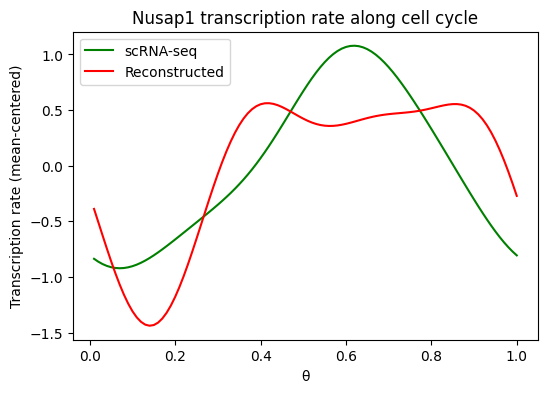

In [30]:
n = np.where(targetnames == 'Nusap1')[0][0]
#n = 6
#print("Train")
print(round(explained_variance_score(alpha1_norm[n, :], R[n, :])*100,2), "%")
plot_rate_comparison(targetnames, alpha1_norm, R, process, theta_smooth, target_nb=n)
#print("Test")
#plot_rate_comparison(targetnames, alpha2_norm, R, process, theta_smooth, target_nb=n)

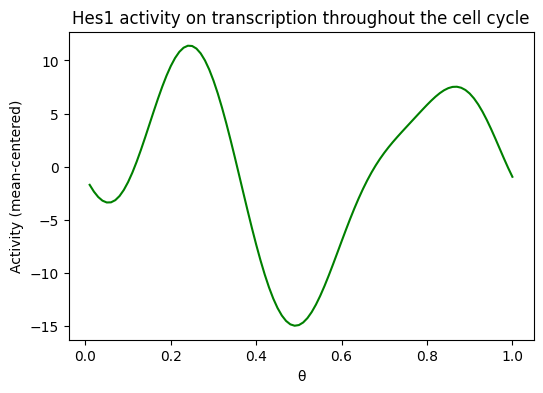

In [31]:
BP_nb = np.where(tf_names == 'Hes1')[0][0]
plot_binding_protein_activity(tf_names, A_star, process, theta_smooth, BP_nb=BP_nb)

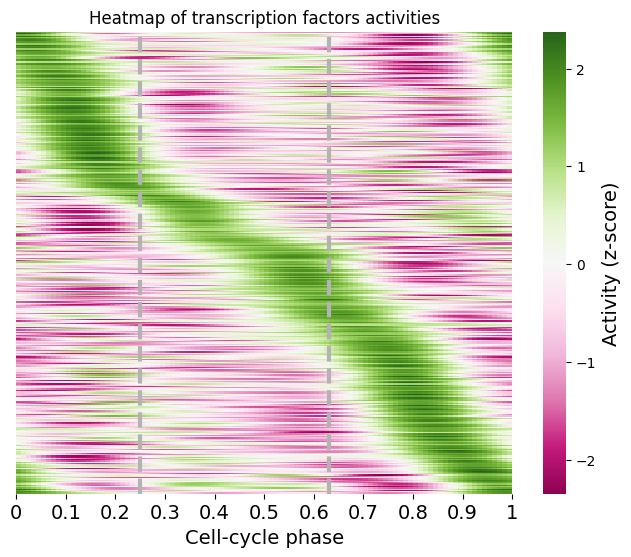

In [32]:
#Heatmap of BPs activity along cell cycle
tf_displayed = plot_heatmap(A_star, cmap='PiYG')
#tf_displayed = plot_heatmap(A, ylabels=tf_names, display_limit=25)
#print(tf_displayed)

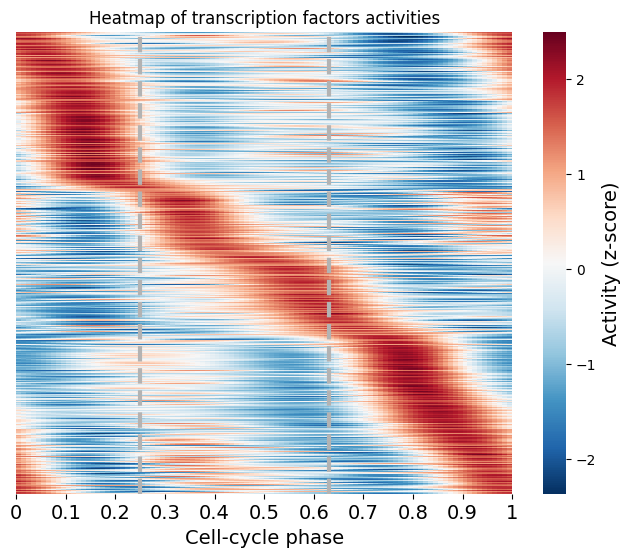

In [33]:
#Heatmap of BPs activity along cell cycle
gene_displayed = plot_heatmap(alpha1_norm)
#print(tf_displayed)

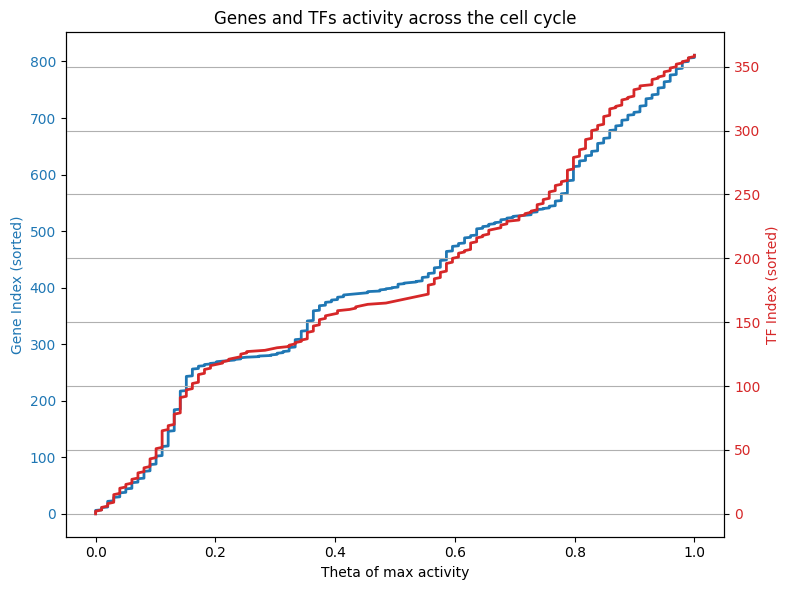

In [34]:
plot_peak_theta_vs_index(alpha1_norm, A_star)

In [35]:
expected_activity = {
    "Smad3": {"ranges": [(0.1, 0.4)], "inhibitory": True},
    "Hbp1": {"ranges": [(0.1, 0.4)], "inhibitory": True},
    "E2f1": {"ranges": [(0.1, 0.4)], "inhibitory": False},
    "E2f2_E2f5": {"ranges": [(0.1, 0.4)], "inhibitory": False},
    "E2f3": {"ranges": [(0.1, 0.4)], "inhibitory": False},
    "E2f4": {"ranges": [(0.01, 0.25)], "inhibitory": False}, #May be True
    "E2f6": {"ranges": [(0.01, 0.25), (0.63, 0.9)], "inhibitory": False}, #May be True
    "E2f7": {"ranges": [(0.4, 0.9)], "inhibitory": False}, #May be True
    "E2f8": {"ranges": [(0.4, 0.9)], "inhibitory": False}, #May be True
    "Sp1": {"ranges": [(0.1, 0.63)], "inhibitory": False},
    "Hes1": {"ranges": [(0.1, 0.4)], "inhibitory": True},
    #"Elf3": {"ranges": [(0.25, 1)], "inhibitory": False},
    #"Tfap4": {"ranges": [(0.63, 0.9)], "inhibitory": False}
}

In [36]:
fileAlphaTF_sc = "/shared/space2/molina/suttyg/TF_Expression/spliced_scrna.csv"
fileAlphaTF_sn1 = "/shared/space2/molina/suttyg/TF_Expression/spliced_snrna_rep1.csv"
fileAlphaTF_sn2 = "/shared/space2/molina/suttyg/TF_Expression/spliced_snrna_rep2.csv"

key_tfs = ["Smad3", "Hbp1", "E2f1", "E2f2", "E2f3", "E2f4", "E2f5", "E2f6", "E2f7", "E2f8", "Sp1", "Hes1"]

#Get spliced RNA data to compare splicing and protein activity dynamics
alpha_sc = pd.read_csv(fileAlphaTF_sc, sep=",",index_col=0)
alpha_sn1 = pd.read_csv(fileAlphaTF_sn1, sep=",",index_col=0)
alpha_sn2 = pd.read_csv(fileAlphaTF_sn2, sep=",",index_col=0)

tf_names_filtered = np.array([tf for tf in key_tfs if tf in alpha_sc.index and tf in alpha_sn1.index and tf in alpha_sn2.index and tf in tf_names])
print("TFs in common :", str(len(tf_names_filtered))+"/"+str(len(key_tfs)))

alpha_sc_f, alpha_sn1_f, alpha_sn2_f = alpha_sc.loc[tf_names_filtered], alpha_sn1.loc[tf_names_filtered], alpha_sn2.loc[tf_names_filtered]
alpha_sc_n, alpha_sn1_n, alpha_sn2_n = alpha_sc_f.to_numpy(), alpha_sn1_f.to_numpy(), alpha_sn2_f.to_numpy()

#Standardize amplitudes
alpha_sc_n, alpha_sn1_n, alpha_sn2_n, A_standard = standardize_amplitudes([alpha_sc_n, alpha_sn1_n, alpha_sn2_n, A_star])
#A_standard = A_standard - np.mean(A_standard, axis=1, keepdims=True)
alpha_sn_n = (alpha_sn1_n + alpha_sn2_n) / 2

alpha_sc_norm = alpha_sc_n - np.mean(alpha_sc_n, axis=1, keepdims=True) - np.mean(alpha_sc_n, axis=0, keepdims=True) + np.mean(alpha_sc_n)
alpha_sn_norm = alpha_sn_n - np.mean(alpha_sn_n, axis=1, keepdims=True) - np.mean(alpha_sn_n, axis=0, keepdims=True) + np.mean(alpha_sn_n)

TFs in common : 10/12


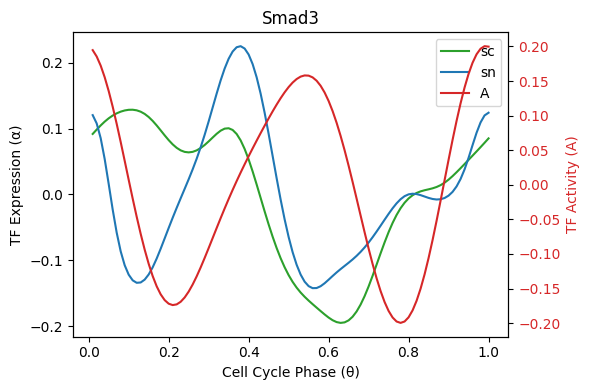

scRNA & A correlation : 0.108 (inhibitor)

Expected activity range : [(0.1, 0.4)]
TF activity biological z-score : 2.70 (inhibitor)


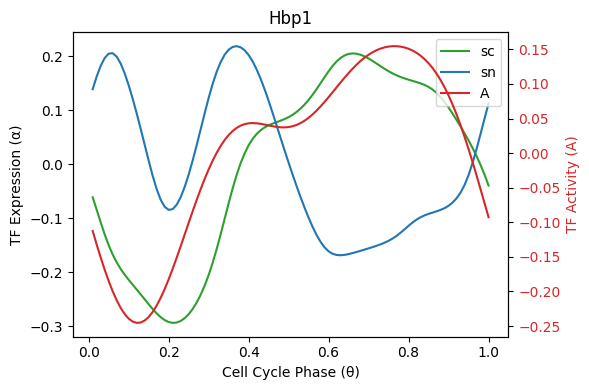

scRNA & A correlation : -0.917 (inhibitor)

Expected activity range : [(0.1, 0.4)]
TF activity biological z-score : 10.40 (inhibitor)


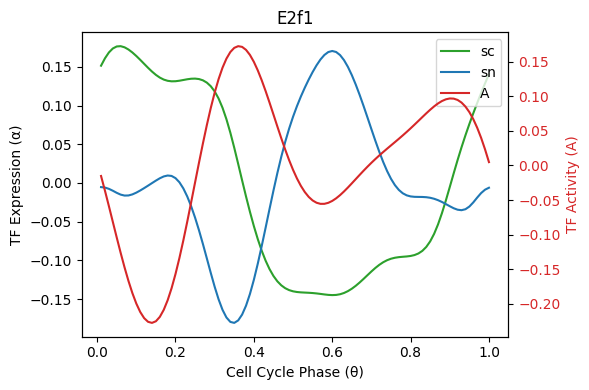

scRNA & A correlation : -0.204 (activator)

Expected activity range : [(0.1, 0.4)]
TF activity biological z-score : -1.60 (activator)


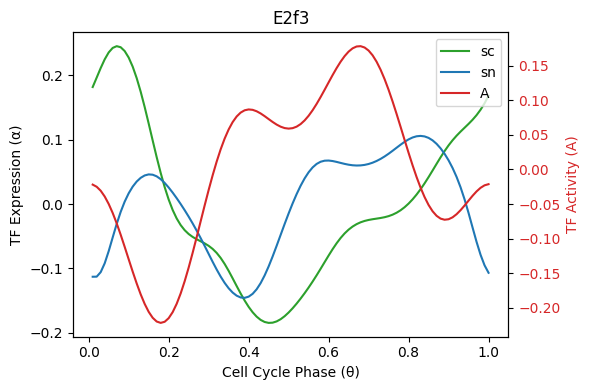

scRNA & A correlation : -0.572 (activator)

Expected activity range : [(0.1, 0.4)]
TF activity biological z-score : -6.83 (activator)


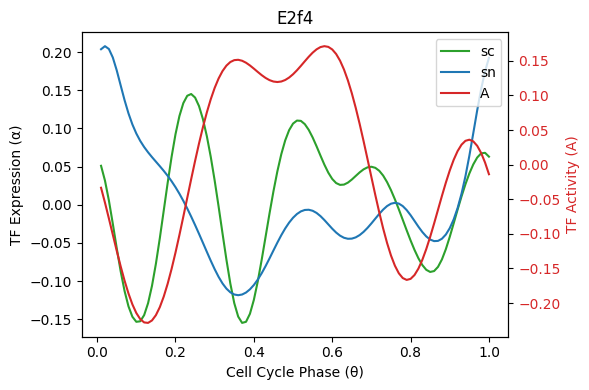

scRNA & A correlation : 0.292 (activator)

Expected activity range : [(0.01, 0.25)]
TF activity biological z-score : -7.36 (activator)


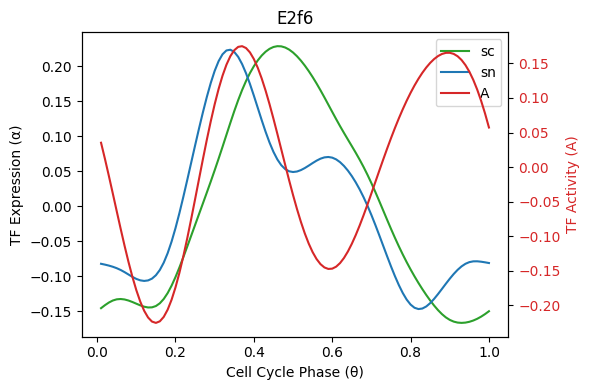

scRNA & A correlation : -0.045 (activator)

Expected activity range : [(0.01, 0.25), (0.63, 0.9)]
TF activity biological z-score : -3.57 (activator)


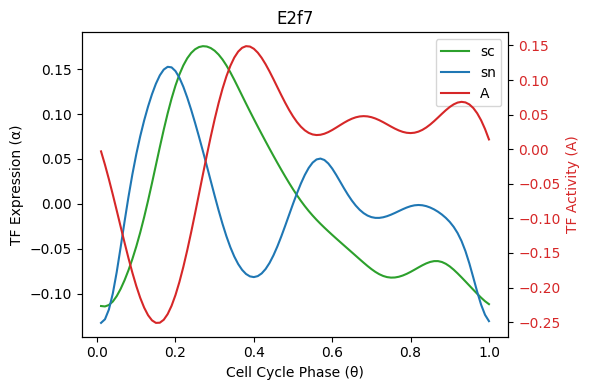

scRNA & A correlation : 0.042 (activator)

Expected activity range : [(0.4, 0.9)]
TF activity biological z-score : 5.19 (activator)


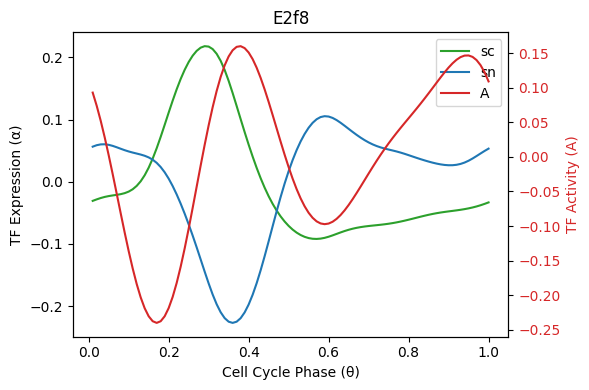

scRNA & A correlation : 0.119 (activator)

Expected activity range : [(0.4, 0.9)]
TF activity biological z-score : 1.06 (activator)


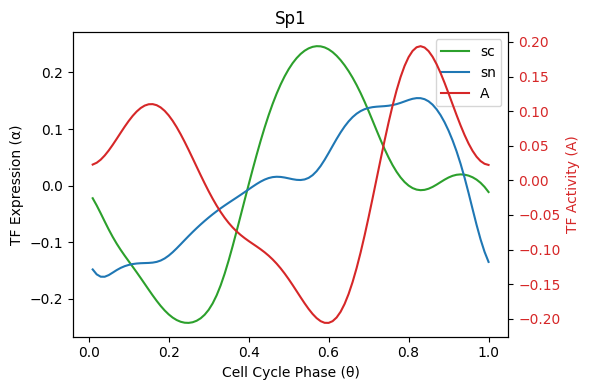

scRNA & A correlation : -0.580 (activator)

Expected activity range : [(0.1, 0.63)]
TF activity biological z-score : -5.42 (activator)


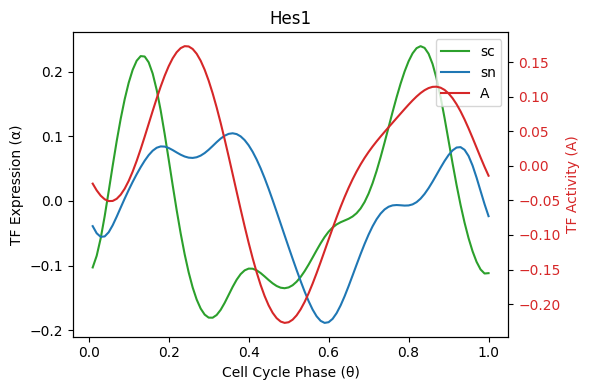

scRNA & A correlation : -0.357 (inhibitor)

Expected activity range : [(0.1, 0.4)]
TF activity biological z-score : -3.89 (inhibitor)
Global correlation :-0.211
Global z-score :-0.93


In [37]:
corrs = []
z_vals = []
for tf in range(len(tf_names_filtered)):
    plot_TF_exp_activity(theta_smooth, alpha_sc_norm, alpha_sn_norm, A_standard, tf_names, tf_names_filtered, tf)
    corr = spearmanr(alpha_sc_norm[tf], A_standard[list(tf_names).index(tf_names_filtered[tf])])[0]
    action = "activator" if not expected_activity[tf_names_filtered[tf]]["inhibitory"] else "inhibitor"
    if (action == "inhibitor"):
        corr = -corr
    print(f"scRNA & A correlation : {corr:.3f} ({ action })\n")
    z_val = compute_tf_activity_difference(A_standard[list(tf_names).index(tf_names_filtered[tf]), :], theta_smooth, expected_activity[tf_names_filtered[tf]]["ranges"], expected_activity[tf_names_filtered[tf]]["inhibitory"])
    corrs.append(corr)
    z_vals.append(z_val)
    print(f"Expected activity range : {expected_activity[tf_names_filtered[tf]]["ranges"]}")
    print(f"TF activity biological z-score : {z_val:.2f} ({ action })")
print(f"Global correlation :{np.mean(corrs):.3f}")
print(f"Global z-score :{np.mean(z_vals):.2f}")

In [38]:
#Demonstration that explained_variance_score calculate EV for columns (theta) and not rows (genes)
EV_train = round(explained_variance_score(alpha1_norm, R)*100,2)
print(EV_train)

#EV for columns (theta independant)
EVs_train = []
for k in range(R.shape[1]):
    EV_train = round(explained_variance_score(alpha1_norm.T[k, :], R.T[k, :])*100,2)
    EVs_train.append(EV_train)
print(np.mean(np.array(EVs_train)))

var_alpha1 = np.var(alpha1_norm)
mse = np.mean((alpha1_norm - R)**2)
ev = 1.0 - mse / var_alpha1
print(ev*100)

#EV for rows (genes independant)
EVs_train = []
for k in range(R.shape[0]):
    EV_train = round(explained_variance_score(alpha1_norm[k, :], R[k, :])*100,2)
    EVs_train.append(EV_train)
print(np.mean(np.array(EVs_train)))

-10.15
-10.152300000000002
-10.100055945492127
-11.646970443349758
